# 2: Multilayer Perceptron (MLP)
Here, we build fully connected neural network.

In [3]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
try:
    import _pickle as pickle
except ImportError:
    import pickle as pickle

from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [6]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers

### Create basic layer functions

Functions are **affine_forward**, **affine_backward** in **./ecbm4040/layer_funcs.py**.

In [7]:
from ecbm4040.layer_funcs import affine_forward
from ecbm4040.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

# Affine function -- H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

# check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./ecbm4040/layer_funcs.py**.

In [8]:
from ecbm4040.layer_funcs import relu_forward
from ecbm4040.layer_funcs import relu_backward

# Activation layers -- Here we introduce ReLU/Leaky ReLU activation functions
# since they are the most commonly used in computer vision problems.

x = X_dev
dout = np.ones(x.shape)
# ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)


# check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
out_tf = tf.nn.relu(x_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)[0]
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check = sess.run(dx_tf)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


Functions **softmax_loss** are in **./ecbm4040/layer_funcs.py**

In [9]:
from ecbm4040.layer_funcs import softmax_loss

# generate some random data for testing
x = np.random.rand(100,10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

# tensorflow gradients
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= x_tf, labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy)
dx_tf = tf.gradients(loss, x)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(loss_tf, x_tf)
with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf)
    dx_check = sess.run(dx_tf)

# Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

Now we combine an affine function and a nonlinear activation function into a single fully-connected layer. The code is in ./ecbm4040/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b})$$

We create two types of layers as below, as in ./ecbm4040/layer_utils.py. 

* DenseLayer -- Affine transform >> ReLU

* AffineLayer -- Affine transform >> Softmax and the class structure is similar to DenseLayer

Function **DenseLayer** is in **./ecbm4040/layer_utils.py**

In [10]:
# First, let's make a dense layer
from ecbm4040.layer_utils import DenseLayer

# Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

# Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients


# Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.nn.relu(tf.matmul(x_tf,w_tf) + b_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


Function **AffineLayer** is in **./ecbm4040/layer_utils.py**

In [11]:
from ecbm4040.layer_utils import AffineLayer

# Affine + ReLU
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

# Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients


# Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: More Backpropogation

Class **TwoLayerNet** is in **./ecbm4040/classifiers/twolayernet.py**. Through this experiment, we create a two-layer neural network. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. 


Class **TwoLayerNet** is in **./ecbm4040/classifiers/twolayernet.py**

In [12]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

# Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=200, num_classes=10, reg=1e-5)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)


# Check loss by tensorflow
x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.uint8, shape=(None,))

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-5*L2_loss 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf, feed_dict={x_tf: X_dev, y_tf: y_dev})
    
# Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [13]:
from ecbm4040.train_funcs import train, test

#### Start training
We use previous layers to create a two layer neural network:

**input->(affine->activation)->(affine->softmax)->output**

The default activation function is ReLU. 

In [20]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=0.25, weight_scale=1e-1)

num_epoch = 10
batch_size = 500
lr = 1e-3
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98


/Users/nathantoubiana/KOSTIC/ecbm4040/layer_funcs.py:188: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


5000/49000 loss: inf
10000/49000 loss: inf
15000/49000 loss: inf
20000/49000 loss: inf
25000/49000 loss: inf
30000/49000 loss: inf
35000/49000 loss: inf
40000/49000 loss: inf
45000/49000 loss: inf
epoch 1: valid acc = 0.134, new learning rate = 0.00095
5000/49000 loss: inf
10000/49000 loss: inf
15000/49000 loss: inf
20000/49000 loss: inf
25000/49000 loss: inf
30000/49000 loss: inf
35000/49000 loss: inf
40000/49000 loss: inf
45000/49000 loss: inf
epoch 2: valid acc = 0.139, new learning rate = 0.0009025
5000/49000 loss: inf
10000/49000 loss: inf
15000/49000 loss: inf
20000/49000 loss: inf
25000/49000 loss: inf
30000/49000 loss: inf
35000/49000 loss: inf
40000/49000 loss: inf
45000/49000 loss: inf
epoch 3: valid acc = 0.169, new learning rate = 0.000857375
5000/49000 loss: inf
10000/49000 loss: inf
15000/49000 loss: inf
20000/49000 loss: inf
25000/49000 loss: inf
30000/49000 loss: inf
35000/49000 loss: inf
40000/49000 loss: inf
45000/49000 loss: inf
epoch 4: valid acc = 0.184, new learni

0.26519999999999999

We plot training and validation accuracy history of each epoch

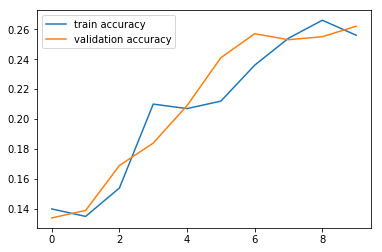

In [21]:
# plot the accuracy history
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

#### Visualize the weight variable in the first layer.

Visualization of the intermediate weights can help get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [22]:
from ecbm4040.display_funcs import visualize_pics

In [23]:
model.layer1.params[0][0].shape

(100,)

num of feature vectors: 100


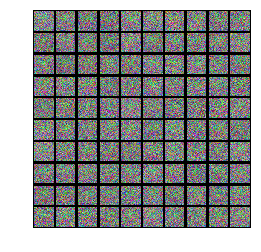

In [24]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
# visualization
visualize_pics(pics)

### Save our best model in a dictionary 

In [30]:
# Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save our model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [ ]:
# Load our model
#with open("./save_models/best_model.pkl", "rb") as input_file:
#    load_params = pickle.load(input_file)
    
#model.update_model(load_params)

## Part 3: Multilayer Net 

The class **MLP** is in **./ecbm4040/classifiers/network.py**. It allows arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network. 


In [165]:
from ecbm4040.classifiers.mlp import MLP

# input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 50, 50], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 2.3076498223261512
10000/49000 loss: 2.3074805221205965
15000/49000 loss: 2.3074055739219936
20000/49000 loss: 2.3072127793847055
25000/49000 loss: 2.307002132429285
30000/49000 loss: 2.306925577461517
35000/49000 loss: 2.30681243985468
40000/49000 loss: 2.3066930717035286
45000/49000 loss: 2.306055561510086
epoch 1: valid acc = 0.12, new learning rate = 0.0095
5000/49000 loss: 2.305192045182845
10000/49000 loss: 2.3050980053355574
15000/49000 loss: 2.3052584648057937
20000/49000 loss: 2.3041679118225913
25000/49000 loss: 2.302546059529764
30000/49000 loss: 2.302036847479381
35000/49000 loss: 2.3013964149706485
40000/49000 loss: 2.2991007867798694
45000/49000 loss: 2.2857609984687373
epoch 2: valid acc = 0.121, new learning rate = 0.009025
5000/49000 loss: 2.2644958063557192
10000/49000 loss: 2.275486554467207
15000/49000 loss: 2.280300598010219
20000/49000 loss: 2.271582909370217
25000/49000 loss: 2.265945074374274
30000/49000 loss: 

0.18559999999999999

## Part 4: Tensorflow MLP
In this part, we use tensorflow modules to implement a MLP. 

In [170]:
# Two-layer net in tensorflow.
hidden_dim = 100
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
b2_tf = tf.Variable(np.zeros((10,)).astype('float32'))

h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(tf.nn.softmax(h2_tf),1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.17800000309944153
epoch 2: valid acc = 0.3310000002384186
epoch 3: valid acc = 0.33899998664855957
epoch 4: valid acc = 0.3319999873638153
epoch 5: valid acc = 0.3610000014305115
epoch 6: valid acc = 0.3889999985694885
epoch 7: valid acc = 0.4000000059604645
epoch 8: valid acc = 0.382999986410141
epoch 9: valid acc = 0.4059999883174896
epoch 10: valid acc = 0.41499999165534973
test acc = 0.41499999165534973


In [189]:
# Four-layer net in tensorflow.
hidden_dim_1 = 10
hidden_dim_2 = 50
hidden_dim_3 = 10
reg_tf = tf.constant(0.02)

weights = {
    'w1': tf.Variable(1e-2*np.random.rand(3072, hidden_dim_1).astype('float32')),
    'w2': tf.Variable(1e-2*np.random.rand(hidden_dim_1, hidden_dim_2).astype('float32')),
    'w3': tf.Variable(1e-2*np.random.rand(hidden_dim_2, hidden_dim_3).astype('float32')),
    'w4': tf.Variable(1e-2*np.random.rand(hidden_dim_3, 10).astype('float32'))
}

biases = {
    'b1': tf.Variable(np.zeros((hidden_dim_1,)).astype('float32')),
    'b2': tf.Variable(np.zeros((hidden_dim_2,)).astype('float32')),
    'b3': tf.Variable(np.zeros((hidden_dim_3,)).astype('float32')),
    'b4': tf.Variable(np.zeros((10,)).astype('float32'))
}


x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

H=[]
X=x_tf
L2_loss=0
for i in range(3):
    L2_loss+=tf.nn.l2_loss(weights['w'+str(i+1)])
    h=tf.nn.relu(tf.matmul(X, weights['w'+str(i+1)]) + biases['b'+str(i+1)])
    H.append(h)
    X=h
    
H.append(tf.matmul(H[-1], weights['w4']) + biases['b4'])
L2_loss+=tf.nn.l2_loss(weights['w4'])

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= H[-1], labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 
    
init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-2).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(H[-1],1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(20):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.1459999978542328
epoch 2: valid acc = 0.14499999582767487
epoch 3: valid acc = 0.1459999978542328
epoch 4: valid acc = 0.1469999998807907
epoch 5: valid acc = 0.14900000393390656
epoch 6: valid acc = 0.1770000010728836
epoch 7: valid acc = 0.19200000166893005
epoch 8: valid acc = 0.1979999989271164
epoch 9: valid acc = 0.19900000095367432
epoch 10: valid acc = 0.20100000500679016
epoch 11: valid acc = 0.20399999618530273
epoch 12: valid acc = 0.20200000703334808
epoch 13: valid acc = 0.19900000095367432
epoch 14: valid acc = 0.2029999941587448
epoch 15: valid acc = 0.20600000023841858
epoch 16: valid acc = 0.21799999475479126
epoch 17: valid acc = 0.23399999737739563
epoch 18: valid acc = 0.24400000274181366
epoch 19: valid acc = 0.2529999911785126
epoch 20: valid acc = 0.25999999046325684
test acc = 0.25999999046325684
